# Hilbert-Huang Transform

The `Hilbert–Huang transform` (`HHT`) is a two-step method for analysis of nonlinear and nonstationary signals. In contrast to other common transforms like the Fourier transform, wavelets, etc. the `HHT` is data-adaptive which leads to more physically meaningful components when compared to wavelet decomposition for example. This decomposition improvement comes at a computation cost. 

The first step is to decompose the orginal signal into a number of components. `Empirical mode decomposition` (`EMD`) is a data-adaptive multi-resolution technique to decompose a signal into a finite number of `intrinsic mode functions` (`IMFs`). IMFs are time-varying mono-component (*single frequency*) functions. The signal is decomposed into `IMFs` in such that the highest frequency components of each event in the signal is captured by the first `IMF`.

The second step of `HHT` is the `Hilbert transform` that produces an orthogonal pair for each IMF that is phase shifted by 90 degrees. Each IMF set and its orthogonal pair can be used to **estimate** the **instantaneous variation** in **magnitude** and **frequency** of the IMF with respect to **time**. Thus, HHT is very useful to extract information from nonlinear and nonstationary time series data such as physiological signals.

## Contents

In this Jupyter Notebook, the full `Hilbert–Huang transform` is implemented and described in detail. As discussed previously the HHT is a two stage process, the Python implementation of Empirical Mode Decomposition (EMD) which is incorperated here is from the [EMD-signal](https://pypi.org/project/EMD-signal/) library (*otherwise known as `PyEMD`*). The **hilbert transform** itself was implemented from scratch and is located in the src folder. 


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl

from scipy.signal import hilbert, spectrogram
from PyEMD import EMD
from sklearn.preprocessing import MinMaxScaler

from src.HHT import *

### Generate Synthetic non-stationary Time Series

To initally test the EMD and full HHT we will initally generate synthetic non-stationary time series data fromt he following equation, to ensure the functions are operating as expected.
$$S(t)=sin(0.05*t) + sin(6*t) + cos(3*t)$$

In [2]:
# define sample frequency of signal
fs = 100
# build elapsed time vector
t = np.arange(0, 30, 0.1)
# build Synthetic non-stationary signal
s = np.sin(0.05*t)+np.sin(6*t)+np.cos(3*t) + 5

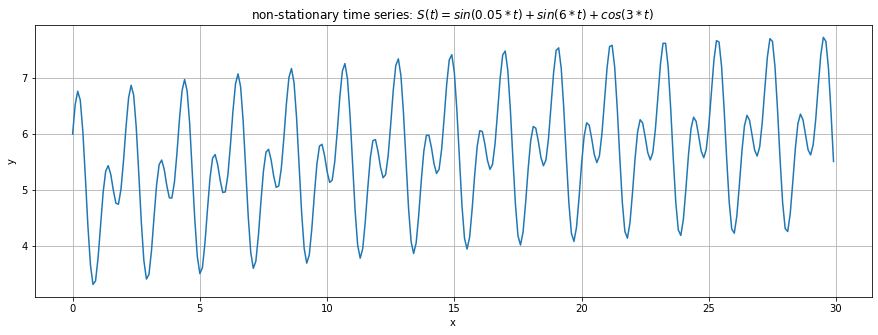

In [3]:
plt.figure(figsize=(15,5))
plt.title('non-stationary time series: $S(t)=sin(0.05*t) + sin(6*t) + cos(3*t)$')
plt.plot( t, s )
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()



In this section, we will provide the background information required to Understand the relationship between `analytic signal`, `Hilbert transform` and `FFT`. 

### Fourier Transform 

[Fourier Transform](https://www.gaussianwaves.com/2015/11/interpreting-fft-results-complex-dft-frequency-bins-and-fftshift/) of a real-valued signal is ***complex-symmetric***. It implies that the content at negative frequencies are redundant with respect to the positive frequencies.


### Hilbert Transform

The `Hilbert transform` is a specific linear operator which 


The `Hilbert transform` facilitates the formation of the [analytic signal](https://en.wikipedia.org/wiki/Analytic_signal). The analytic signal is useful in the area of communications, particularly in bandpass signal processing. The toolbox function hilbert computes the Hilbert transform for a real input sequence x and returns a complex result of the same length, y = hilbert(x), where the real part of y is the original real data and the imaginary part is the actual Hilbert transform. y is sometimes called the analytic signal, in reference to the continuous-time analytic signal. A key property of the discrete-time analytic signal is that its Z-transform is 0 on the lower half of the unit circle. Many applications of the analytic signal are related to this property; for example, the analytic signal is useful in avoiding aliasing effects for bandpass sampling operations. The magnitude of the analytic signal is the complex envelope of the original signal.

The Hilbert transform is related to the actual data by a 90-degree phase shift; sines become cosines and vice versa. To plot a portion of data and its Hilbert transform, use


In mathematics and in signal processing, the Hilbert transform is a specific linear operator that takes a function, u(t) of a real variable and produces another function of a real variable H(u)(t). This linear operator is given by convolution with the function {\displaystyle 1/(\pi t)}{\displaystyle 1/(\pi t)} (see § Definition). The Hilbert transform has a particularly simple representation in the frequency domain: It imparts a phase shift of ±90° (π⁄2 radians) to every frequency component of a function, the sign of the shift depending on the sign of the frequency (see § Relationship with the Fourier transform). The Hilbert transform is important in signal processing, where it is a component of the analytic representation of a real-valued signal u(t). The Hilbert transform was first introduced by David Hilbert in this setting, to solve a special case of the Riemann–Hilbert problem for analytic functions.

$$ x_a = F^{-1}(F(x) 2U) = x + i y $$

The analytic signal x_a(t) of signal x(t) is:

where F is the Fourier transform, U the unit step function, and y the Hilbert transform of x. [1]

In other words, the negative half of the frequency spectrum is zeroed out, turning the real-valued signal into a complex signal. The Hilbert transformed signal can be obtained from np.imag(hilbert(x)), and the original signal from np.real(hilbert(x)).



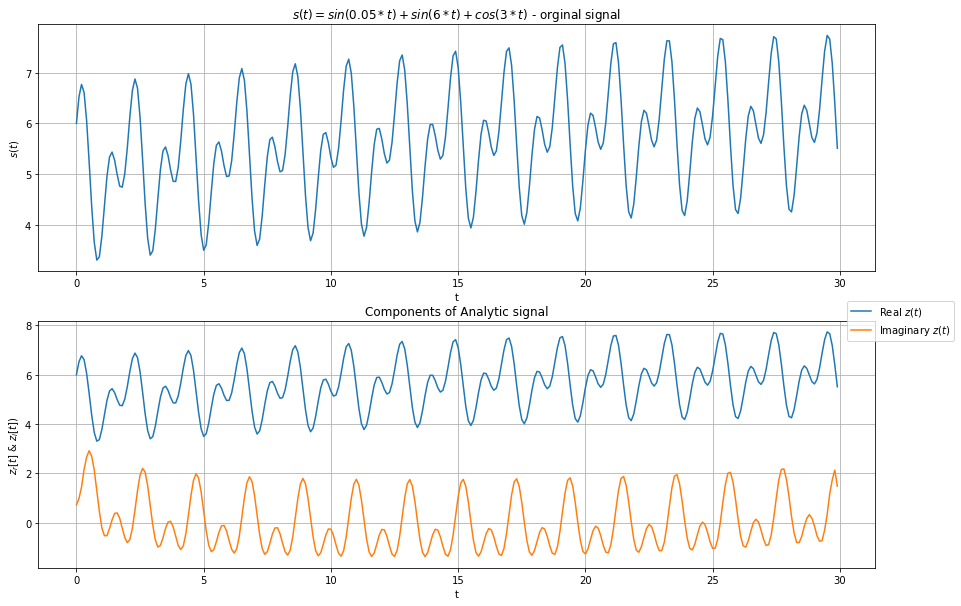

In [4]:
fig, ax = plt.subplots(2, 1,figsize=(15,10))

ax[0].title.set_text('$s(t)=sin(0.05*t) + sin(6*t) + cos(3*t)$ - orginal signal')
ax[0].plot( t, s )
ax[0].set_xlabel('t')
ax[0].set_ylabel('$s(t)$')
ax[0].grid()

ax[1].title.set_text('Components of Analytic signal')
ax[1].plot(t, hilbert(s).real, label = 'Real $z(t)$')
ax[1].plot(t, hilbert(s).imag, label = 'Imaginary $z(t)$')
ax[1].set_xlabel('t')
ax[1].set_ylabel('$z_r[t]$ & $z_i[t] )$')
ax[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
ax[1].grid()

plt.show()

### Empirical mode decomposition (EMD)

The EMD method is a necessary step to reduce any given data into a collection of intrinsic mode functions (IMF) to which the Hilbert spectral analysis can be applied.

IMF represents a simple oscillatory mode as a counterpart to the simple harmonic function, but it is much more general: instead of constant amplitude and frequency in a simple harmonic component, an IMF can have variable amplitude and frequency along the time axis.

The procedure of extracting an IMF is called sifting. The sifting process is as follows:

Identify all the local extrema in the test data.
Connect all the local maxima by a cubic spline line as the upper envelope.
Repeat the procedure for the local minima to produce the lower envelope

In [5]:
n_components = 4
# decompose signal into imfs and residue
emd = EMD(max_imfs=n_components)
emd.emd(s)
imfs, res = emd.get_imfs_and_residue()
n_components = imfs.shape[0] + 2

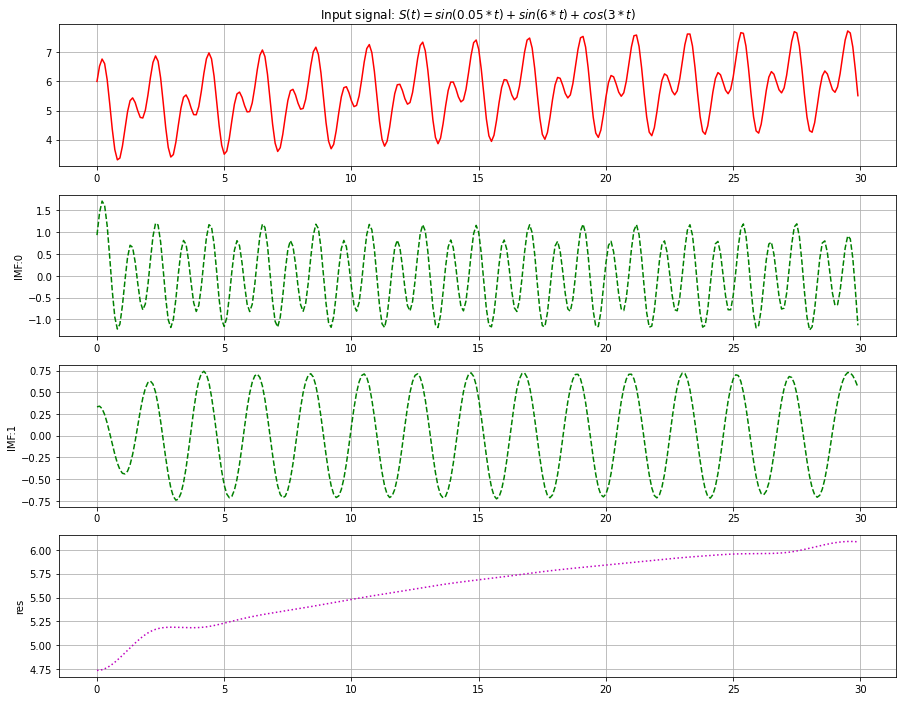

In [6]:
plt.figure(figsize=(15,12))
plt.subplot(n_components,1,1)
plt.plot(t, s, 'r')
plt.title("Input signal: $S(t)=sin(0.05*t) + sin(6*t) + cos(3*t)$")
plt.grid()

for n, imf in enumerate( imfs ):
    plt.subplot(n_components,1,n+2)
    plt.plot(t, imf, '--g')
    plt.ylabel('IMF:'+str(n))
    plt.grid()

n+=1
plt.subplot(n_components,1,n+2)
plt.plot(t, res, ':m')
plt.ylabel("res")
plt.grid()

#plt.savefig('simple_example')
plt.show()

### Reconstruct Original Signal
Retrieve original signal using IMF summation as below
$$E=r_n(t)\sum\limits_{i=1}^{n}IMF_i(t)$$

Residual of the signal, returned as a column vector or a single data column timetable. residual represents the portion of the original signal X not decomposed by emd.

residual is returned as:

A column vector, when X is a vector.

In [7]:
s_recomposition = invEMD(imfs,res)

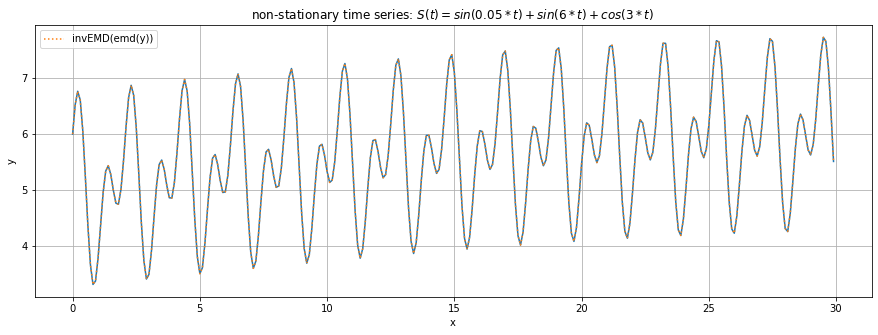

In [8]:
plt.figure(figsize=(15,5))
plt.title('non-stationary time series: $S(t)=sin(0.05*t) + sin(6*t) + cos(3*t)$')
plt.plot( t, s )
plt.plot( t, s_recomposition,":",label = "invEMD(emd(y))")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

### HHT

In [9]:
cmap = plt.cm.cividis

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

color=cm.rainbow(np.linspace(0,1,n_components+2))

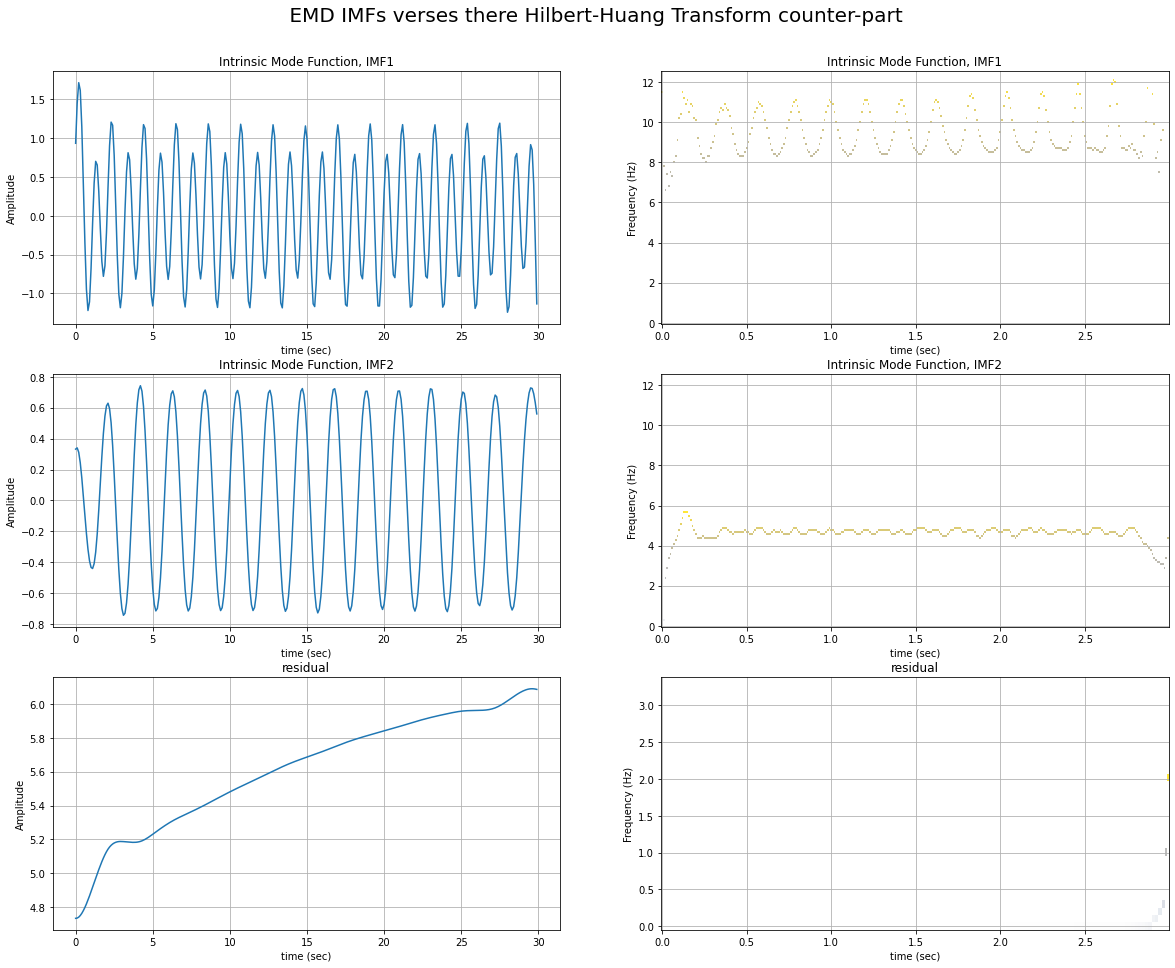

In [10]:
fig, axes = plt.subplots(n_components-1, 2, figsize=(20,15))
fig.suptitle(''' EMD IMFs verses there Hilbert-Huang Transform counter-part''', fontsize=20)
plt.subplots_adjust(top=0.92,hspace=0.2)

imf_freq_limit = [8,8,24,4]
freq_res = [0.1,0.01,0.01,0.01]

for n, (imf, freq_div) in enumerate( zip( imfs, imf_freq_limit) ):
    
    axes[n][0].title.set_text('Intrinsic Mode Function, IMF'+str(n+1))
    axes[n][0].plot( t, imf )
    axes[n][0].set_xlabel('time (sec)')
    axes[n][0].set_ylabel('Amplitude')
    axes[n][0].grid()
    
    T, F, P, insf, inse = hht(imf, fs, FResol= 0.1, freq_min = 0, freq_max = fs/freq_div)
    
    axes[n][1].title.set_text('Intrinsic Mode Function, IMF'+str(n+1))
    axes[n][1].pcolormesh(T,F, P.toarray(),cmap = my_cmap)
    axes[n][1].set_xlabel('time (sec)')
    axes[n][1].set_ylabel('Frequency (Hz)')
    axes[n][1].grid()

axes[n+1][0].title.set_text('residual')
axes[n+1][0].plot( t, res )
axes[n+1][0].set_xlabel('time (sec)')
axes[n+1][0].set_ylabel('Amplitude')
axes[n+1][0].grid()
    
T, F, P, insf, inse = hht(res, fs, FResol= 0.1, freq_min = 0, freq_max = fs/30)

axes[n+1][1].title.set_text('residual')
axes[n+1][1].pcolormesh(T,F, P.toarray(),cmap = my_cmap)
axes[n+1][1].set_xlabel('time (sec)')
axes[n+1][1].set_ylabel('Frequency (Hz)')
axes[n+1][1].grid()

plt.show()

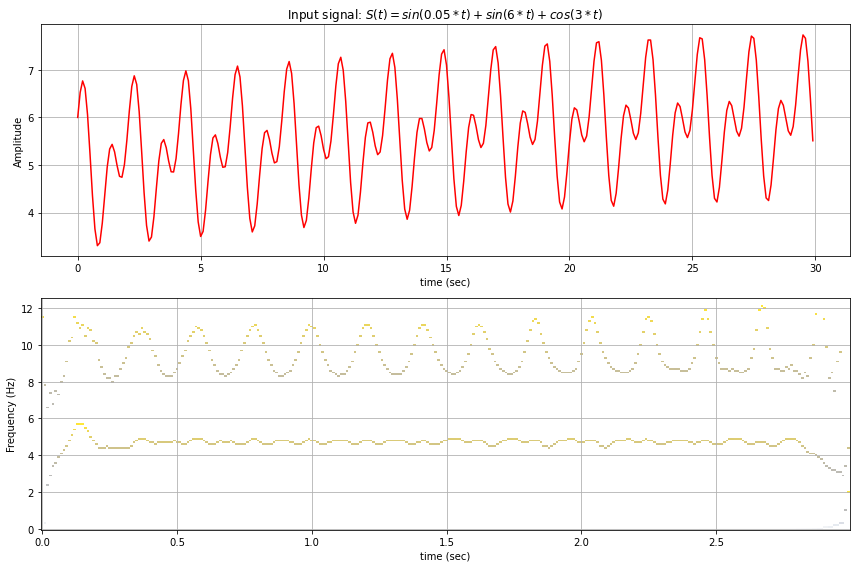

In [11]:
frequency_resolution = 0.01

fig, ax = plt.subplots(2, 1,figsize=(12,8))

ax[0].plot(t, s, 'r')
ax[0].title.set_text("Input signal: $S(t)=sin(0.05*t) + sin(6*t) + cos(3*t)$")
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('time (sec)')
ax[0].grid()

for n, (imf, freq_div) in enumerate( zip( imfs, imf_freq_limit) ):
    
    T, F, P, insf, inse = hht(imf, fs, FResol= 0.1, freq_min = 0, freq_max = fs/freq_div)
    
    ax[1].pcolormesh(T,F, P.toarray(),cmap = my_cmap)
    
T, F, P, insf, inse = hht(res, fs, FResol= 0.1, freq_min = 0, freq_max = fs/30)

ax[1].pcolormesh(T,F, P.toarray(),cmap = my_cmap)

ax[1].set_xlabel('time (sec)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].grid()
plt.tight_layout()
#plt.savefig('simple_example')
plt.show()

6.612935194528628 12.187958463289004


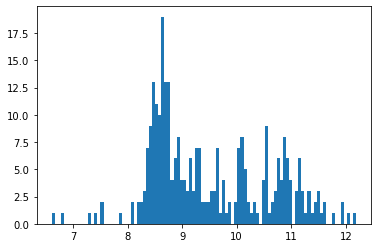

0.38095415951870587 5.782779984760397


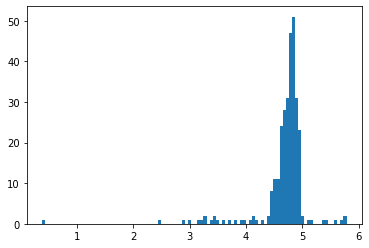

In [12]:
for n, imf in enumerate( imfs ):
    
    T, F, P, insf, inse = hht(imf, fs, FResol= frequency_resolution, freq_min = 0, freq_max = fs/8)
    print(P.toarray()[P.toarray() != 0].min(), P.toarray()[P.toarray() != 0].max())#
    plt.hist(P.toarray()[P.toarray() != 0],bins = 100)
    plt.show()

In [12]:
from matplotlib.colors import LinearSegmentedColormap

# get colormap
ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))

# change alpha values
color_array[:,-1] = np.linspace(1.0,0.0,ncolors)

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

In [13]:
cmap = plt.cm.cividis

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# # Set alpha
# my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# # Create new colormap
# my_cmap = ListedColormap(my_cmap)

# color=cm.rainbow(np.linspace(0,1,n_components+2))

In [14]:
from matplotlib.colors import DivergingNorm

ImportError: cannot import name 'DivergingNorm' from 'matplotlib.colors' (C:\ProgramData\Anaconda3\envs\hht\lib\site-packages\matplotlib\colors.py)

NameError: name 'DivergingNorm' is not defined

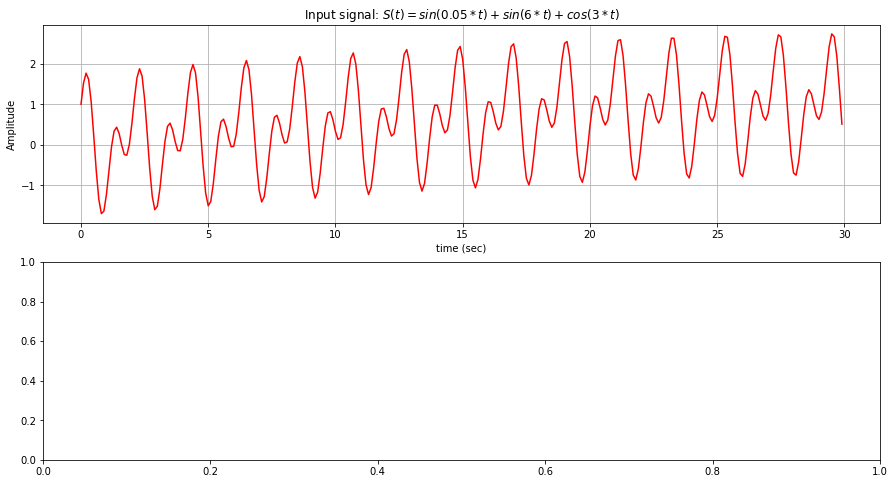

In [15]:
frequency_resolution = 0.01
from matplotlib.colors import ListedColormap


# Choose colormap
cmap = pl.cm.Reds

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)


fig, ax = plt.subplots(2, 1,figsize=(15,8))

ax[0].plot(t, s, 'r')
ax[0].title.set_text("Input signal: $S(t)=sin(0.05*t) + sin(6*t) + cos(3*t)$")
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('time (sec)')
ax[0].grid()

for n, imf in enumerate( imfs ):
    
    T, F, P, insf, inse = hht(imf, fs, FResol= frequency_resolution, freq_min = 0, freq_max = fs/8)
    
    if n ==0:
        norm = DivergingNorm(vmin=0.0074985564752597725, vcenter=6, vmax=12.187958463289004)
    ax[1].pcolormesh(T,F, P.toarray(),cmap = my_cmap )

T, F, P, insf, inse = hht(res, fs, FResol= frequency_resolution, freq_min = 0, freq_max = fs/8)

# ax[1].pcolormesh(T,F, P.toarray(),cmap = 'seismic')
# ax[1].grid()
# ax[1].title.set_text('Hilbert-Huang Transform')
# ax[1].set_xlabel('time (sec)')
# ax[1].set_ylabel('Frequency (Hz)')

plt.tight_layout()
#plt.savefig('simple_example')
plt.show()

### load in Physiologic Waveforms


We will use patient **p000188** to verify our process as this patient as a number of ICU admissions (similar to a number of patients in the mimic datset) and we will need to identify a single ICU admission to extract our final dataset form. 

In [16]:
# load in Physiologic Waveforms
ppg = pd.read_hdf('./data/physiological_signals.h5', key='ppg', mode='r')
ecg = pd.read_hdf('./data/physiological_signals.h5', key='ecg', mode='r')
abp = pd.read_hdf('./data/physiological_signals.h5', key='abp', mode='r')

In [17]:
fs = 125
n_components = 4
# build elapsed time vector, used for plotting - (number of columns = lenght of waveform segiments)
t = np.linspace(0, (ppg.shape[1])*(1/fs), num=(ppg.shape[1]))
# Get shape of Waveform datasets
ppg.shape, ecg.shape, abp.shape

((3, 5000), (3, 5000), (3, 5000))

In [18]:
ppg.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,1.406647,1.459433,1.531769,1.618768,1.718475,1.811339,1.899316,1.997067,2.091887,2.172043,...,1.594330,1.594330,1.594330,1.594330,1.594330,1.594330,1.594330,1.596285,1.601173,1.608993
1,1.298143,1.342131,1.400782,1.474096,1.561095,1.656891,1.758553,1.862170,1.951124,2.030303,...,1.456500,1.454545,1.447703,1.436950,1.424242,1.409580,1.394917,1.384164,1.376344,1.372434
2,1.785924,1.796676,1.809384,1.825024,1.842620,1.861193,1.878788,1.895406,1.910068,1.922776,...,3.964809,3.979472,3.991202,3.997067,4.000000,3.643206,3.109482,2.846530,2.717498,2.653959


In [19]:
ecg.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.204790,0.219941,0.229717,0.244868,0.260020,0.269795,0.284946,0.289834,0.280059,0.269795,...,0.134897,0.134897,0.144673,0.154936,0.154936,0.154936,0.159824,0.174976,0.179863,0.189638
1,0.184751,0.199902,0.214565,0.224829,0.239980,0.254643,0.269795,0.280059,0.284946,0.289834,...,0.124633,0.129521,0.134897,0.139785,0.149560,0.154936,0.159824,0.169599,0.179863,0.184751
2,0.439941,0.459961,0.470215,0.470215,0.470215,0.479980,0.484863,0.495117,0.520020,0.535156,...,0.484863,0.490234,0.484863,0.509766,0.490234,0.470215,0.459961,0.459961,0.459961,0.479980


In [20]:
abp.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,76.294491,76.734088,78.199411,81.178901,86.112156,92.950330,101.058452,109.948079,118.788862,127.287736,...,79.029761,78.883228,78.687852,78.492476,78.248255,77.906346,77.564438,77.027152,76.685244,76.636400
1,52.556256,52.360880,52.800477,54.168112,56.854537,60.859754,65.744164,71.068172,76.441023,81.667342,...,50.358272,50.211739,50.065207,49.869830,49.625610,49.381389,49.186013,49.186013,49.625610,50.749024
2,72.504118,73.383311,75.200309,78.541243,84.168078,92.432493,102.982809,114.470931,125.079860,133.168436,...,80.182403,73.324698,68.225378,66.525605,68.225378,70.569893,70.100990,65.587799,59.257609,54.685806


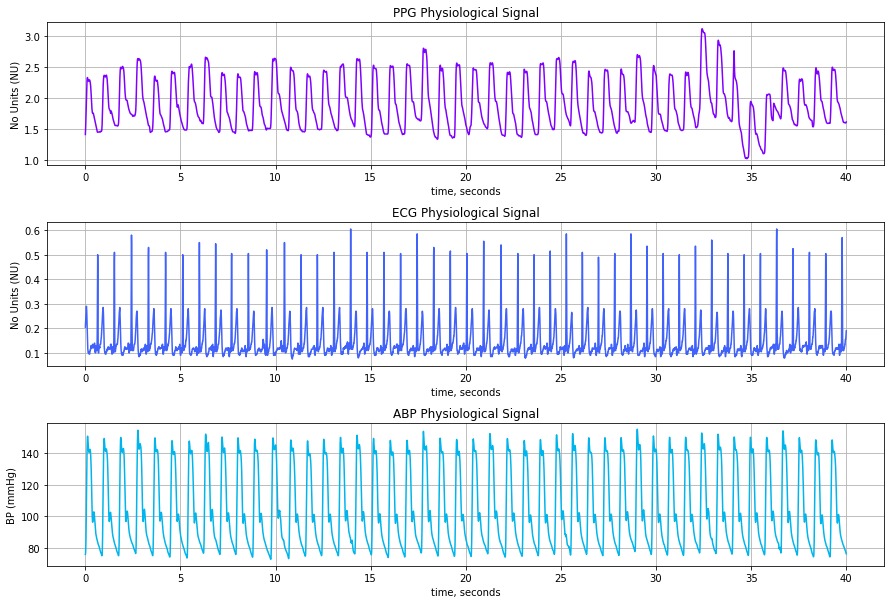

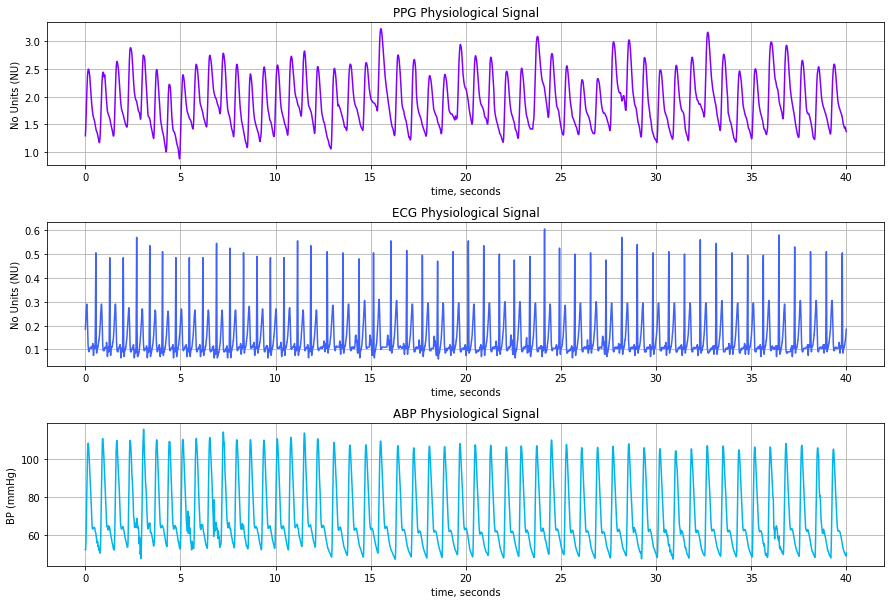

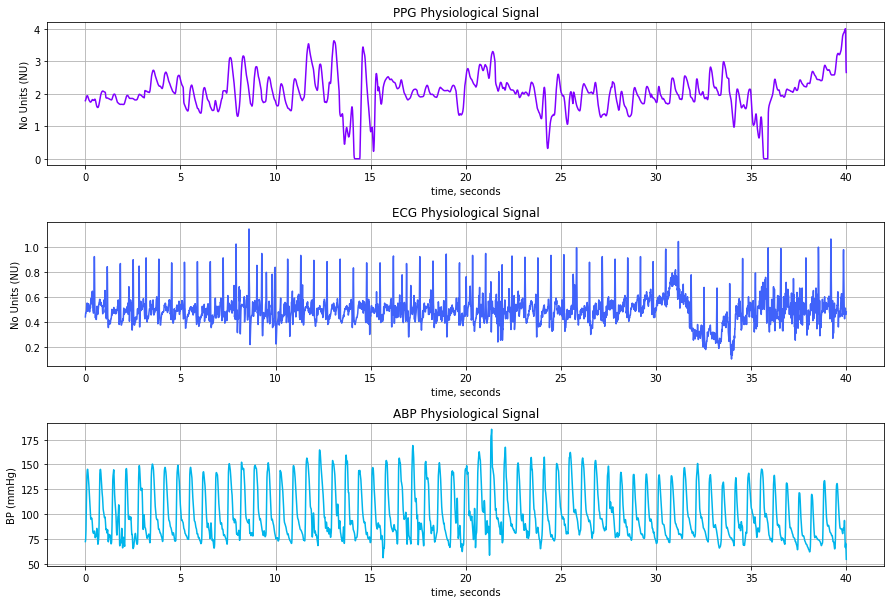

In [21]:
for sig in range(3):
    
    fig, axes = plt.subplots(3, 1, figsize=(15,10))
    plt.subplots_adjust(hspace=0.4)

    color = cm.rainbow(np.linspace(0,1,9))

    axes[0].title.set_text('PPG Physiological Signal')
    axes[0].plot(t,ppg.values[sig],color=color[0])
    axes[0].set_xlabel('time, seconds')
    axes[0].set_ylabel('No Units (NU)')
    axes[0].grid()

    axes[1].title.set_text('ECG Physiological Signal')
    axes[1].plot(t,ecg.values[sig],color=color[1])
    axes[1].set_xlabel('time, seconds')
    axes[1].set_ylabel('No Units (NU)')
    axes[1].grid()

    axes[2].title.set_text('ABP Physiological Signal')
    axes[2].plot(t,abp.values[sig],color=color[2])
    axes[2].set_xlabel('time, seconds')
    axes[2].set_ylabel('BP (mmHg)')
    axes[2].grid()
    plt.show()

In [36]:
n_plots = 3
n_icu_instances = True
icu_single = False
components = 4

color=cm.rainbow(np.linspace(0,1,components+2))
emd = EMD(max_imfs=components)
i,cn = 0, 0
for icu_admission in ppg.datetime.unique():
    for n in range(n_plots):
        fig, axes = plt.subplots(components+2, 2, figsize=(25,30))
        fig.suptitle(''' The spectra of Intrinsic Mode Functions (IMFs) by EMD for Photoplethysmography (PPG) & arterial blood pressure (ABP) waveforms''', fontsize=20)
        plt.subplots_adjust(top=0.95,hspace=0.4)
        
        X = ppg[ppg.datetime == icu_admission].values[i]
        
        emd.emd(X, max_imf = components)
        imfs_ppg, res_ppg = emd.get_imfs_and_residue()
        
        Y = abp[abp.datetime == icu_admission].values[i]
        
        emd.emd(Y, max_imf = components)
        imfs_abp, res_abp = emd.get_imfs_and_residue()
        
        axes[0][0].title.set_text('ppg wavefrom icu admission '+ppg.datetime[ppg.datetime == icu_admission].values[i])
        axes[0][0].plot(t, X, 'r')
        axes[0][0].set_xlabel('time (sec)')
        axes[0][0].set_ylabel('No Units (NU)')
        axes[0][0].grid()
        
        for n, imf in enumerate(imfs_ppg):
            axes[n+1][0].title.set_text('ppg Intrinsic Mode Function, IMF'+str(n+1))
            axes[n+1][0].plot(t, imf, '--g')
            axes[n+1][0].set_xlabel('time (sec)')
            axes[n+1][0].grid()
        
        axes[n+2][0].title.set_text('ppg Residual')
        axes[n+2][0].plot(t, res_ppg, 'pink')
        axes[n+2][0].set_xlabel('time (sec)')
        axes[n+2][0].grid()
            
        axes[0][1].title.set_text('abp wavefrom icu admission '+ppg.datetime[ppg.datetime == icu_admission].values[i])
        axes[0][1].plot(t,Y,color=color[cn+1])
        axes[0][1].set_xlabel('time (sec)')
        axes[0][1].grid()
        
        for n, imf in enumerate(imfs_abp):
            axes[n+1][1].title.set_text('abp Intrinsic Mode Function, IMF'+str(n+1))
            axes[n+1][1].plot(t, imf, '--g')
            axes[n+1][1].set_xlabel('time (sec)')
            axes[n+1][1].grid()
        
        axes[n+2][1].title.set_text('abp Residual')
        axes[n+2][1].plot(t,res_abp,color=color[cn+1])
        axes[n+2][1].set_xlabel('time (sec)')
        axes[n+2][1].grid()
        
        
        if n_icu_instances: break
    if icu_single: break

AttributeError: 'DataFrame' object has no attribute 'datetime'

In [23]:
n_plots = 3
n_icu_instances = True
icu_single = True

imf_freq_limit = [5,30,40,40]
freq_res = [0.1,0.01,0.01,0.01]

In [24]:
cmap = plt.cm.cividis

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

color=cm.rainbow(np.linspace(0,1,components+2))

NameError: name 'components' is not defined

In [25]:
emd = EMD(max_imfs=components)
i,cn = 0, 0
for icu_admission in ppg.datetime.unique():
    for n in range(n_plots):
        fig, axes = plt.subplots(components+2, 2, figsize=(25,30))
        fig.suptitle(''' The spectra of Intrinsic Mode Functions (IMFs) by EMD for Photoplethysmography (PPG) & arterial blood pressure (ABP) waveforms''', fontsize=20)
        plt.subplots_adjust(top=0.95,hspace=0.4)
        
        X = ppg[ppg.datetime == icu_admission].drop(columns=['datetime']).values[i]
        
        emd.emd(X, max_imf = components)
        imfs_ppg, res_ppg = emd.get_imfs_and_residue()
        
        Y = abp[abp.datetime == icu_admission].drop(columns=['datetime']).values[i]
        
        emd.emd(Y, max_imf = components)
        imfs_abp, res_abp = emd.get_imfs_and_residue()
        
        axes[0][0].title.set_text('ppg wavefrom icu admission '+ppg.datetime[ppg.datetime == icu_admission].values[i])
        axes[0][0].plot(t, X, 'r')
        axes[0][0].set_xlabel('time (sec)')
        axes[0][0].set_ylabel('No Units (NU)')
        axes[0][0].grid()
        
        for n, (imf,freq_limit,fres) in enumerate(zip(imfs_ppg,imf_freq_limit,freq_res)):
            
            T,F,P,insf,inse = hht(imf, fs, FResol= fres, freq_min = 0, freq_max = fs/freq_limit)
            
            axes[n+1][0].title.set_text('ppg Intrinsic Mode Function, IMF'+str(n+1))
            axes[n+1][0].pcolormesh(T,F, P.toarray(),cmap = my_cmap)
            axes[n+1][0].set_xlabel('time (sec)')
            axes[n+1][0].set_ylabel('Frequency (Hz)')
            axes[n+1][0].grid()
        
        T,F,P,insf,inse = hht(res_ppg, fs, FResol= fres, freq_min = 0, freq_max = fs/2)
        
        axes[n+2][0].title.set_text('ppg Residual')
        axes[n+2][0].pcolormesh(T,F, P.toarray(),cmap = my_cmap)
        axes[n+2][0].set_xlabel('time (sec)')
        axes[n+1][0].set_ylabel('Frequency (Hz)')
        axes[n+2][0].grid()
            
        axes[0][1].title.set_text('abp wavefrom icu admission '+ppg.datetime[ppg.datetime == icu_admission].values[i])
        axes[0][1].plot(t,Y,color=color[cn+1])
        axes[0][1].set_xlabel('time (sec)')
        axes[0][1].grid()
        
        for n, (imf,freq_limit,fres) in enumerate(zip(imfs_abp,imf_freq_limit,freq_res)):
            T,F,P,insf,inse = hht(imf, fs, FResol= fres, freq_min = 0, freq_max = fs/freq_limit)
            
            axes[n+1][1].title.set_text('abp Intrinsic Mode Function, IMF'+str(n+1))
            axes[n+1][1].pcolormesh(T,F, P.toarray(),cmap = my_cmap)
            axes[n+1][1].set_xlabel('time (sec)')
            axes[n+1][1].set_ylabel('Frequency (Hz)')
            axes[n+1][1].grid()
        
        T,F,P,insf,inse = hht(res_abp, fs, FResol= 0.1, freq_min = 0, freq_max = fs/2)
        
        axes[n+2][1].title.set_text('abp Residual')
        axes[n+2][1].pcolormesh(T,F, P.toarray(),cmap = my_cmap)
        axes[n+2][1].set_xlabel('time (sec)')
        axes[n+1][1].set_ylabel('Frequency (Hz)')
        axes[n+2][1].grid()
        
        
        if n_icu_instances: break
    if icu_single: break

NameError: name 'components' is not defined

In [26]:
imf.shape

(300,)

In [27]:
res_abp.shape

NameError: name 'res_abp' is not defined

In [28]:
T,F,P,insf,inse = hht(res_abp, fs, FResol= 0.1, freq_min = 0, freq_max = fs/100)

NameError: name 'res_abp' is not defined

In [29]:
P.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

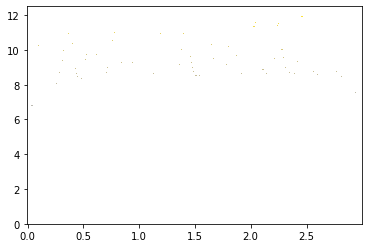

In [30]:
plt.pcolormesh(T,F, P.toarray(),cmap = my_cmap)

In [31]:
cmap = pl.cm.cividis

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

for n, (imf,freq_limit,freq_res) in enumerate(zip(imfs_ppg,[12,30,40,40],[0.1,0.01,0.01,0.01])):
    #plt.plot(imf)
    T,F,P,insf,inse = hht(imf,fs,FResol= freq_res,
                          freq_min = 0,freq_max =fs/2)
    
    scaler = MinMaxScaler()
    scaler.fit(P.toarray())
    
    #np.min(P[np.nonzero(P)]) P.max() cmap = "RdYlBu",
    cmap = plt.cm.Reds
    img = plt.pcolormesh(T,F, P.toarray(),cmap = my_cmap)#seismic
    
    #plt.colorbar()
    plt.title('IMF '+str(n))
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    #plt.show()
    #break

NameError: name 'imfs_ppg' is not defined

In [32]:

emd = EMD(max_imfs=4)
for i,sig_ppg in ppg.drop(columns =['datetime']).iterrows():
    emd.emd(sig_ppg.values,max_imf = 4)
    imfs, res = emd.get_imfs_and_residue()
    break

KeyError: "['datetime'] not found in axis"

In [ ]:
#img.to_rgba(img.get_array().reshape(P.toarray()[:-1, :-1].shape))

In [ ]:
#retrieve rgba values of the quadmesh object
rgbas = img.to_rgba(img.get_array().reshape(P.toarray()[:-1, :-1].shape))

In [ ]:
rgbas.shape

In [ ]:
#modify the alpha values
rgbas[:, :, 3] = np.linspace(0, 1, P.toarray()[:-1, :-1].size).reshape(P.toarray()[:-1, :-1].shape)

In [ ]:
rgbas.shape

In [33]:
ax2.imshow(rgbas, origin="lower")

NameError: name 'ax2' is not defined

In [34]:
# https://stackoverflow.com/questions/34840366/matplotlib-pcolormesh-get-array-returns-flattened-array-how-to-get-2d-dat 
ex_img = img.get_array().reshape(h-1, w-1)# img._meshWidth, img._meshHeight
ex_img.shape

NameError: name 'img' is not defined